## **Installing Requirements**

In [ ]:
# install requirements
import sys
if 'google.colab' in sys.modules:
    print('Running in Colab.')
    !pip3 install transformers==4.18.0 timm==0.4.12 fairscale==0.4.4
    !git clone https://github.com/cxx5208/FYP-YESH
    %cd FYP-YESH

Running in Colab.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 30.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.0/377.0 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.4/235.4 kB 11.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.6/880.6 kB 43.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 40.5 MB/s eta 0:00:00
  Created wheel for fairscale: filename=fairscale-0.4.4-py3-none-any.whl size=292853 sha256=945773423e89528692f40536cc984ce99b97e54458c70b74f12fd2148ab7519d
  Stored in directory: /r

## **Mounting Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install torch torchvision torchaudio
!pip install ruamel_yaml
!pip install torch torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.6/485.6 kB 23.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# **Load a demo image**

In [ ]:
from PIL import Image
import requests
import torch
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def load_demo_image(image_size,device):
    img_url = 'https://www.statueoflibertytour.com/wp-content/uploads/2022/02/Statue-of-Liberty-768x1024.jpg' 
    raw_image = Image.open(requests.get(img_url, stream=True).raw).convert('RGB')   

    w,h = raw_image.size
    display(raw_image.resize((w//5,h//5)))
    
    transform = transforms.Compose([
        transforms.Resize((image_size,image_size),interpolation=InterpolationMode.BICUBIC),
        transforms.ToTensor(),
        transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
        ]) 
    image = transform(raw_image).unsqueeze(0).to(device)   
    return image

## **Visual Question Answering**


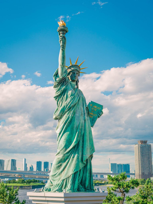

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

load checkpoint from /content/drive/MyDrive/models/model_vqa.pth
answer: statue of liberty


In [ ]:
from models.FYP_vqa import FYP_vqa

image_size = 480
image = load_demo_image(image_size=image_size, device=device)     

model_url = '/content/drive/MyDrive/models/model_vqa.pth'
    
model = FYP_vqa(pretrained=model_url, image_size=image_size, vit='base')
model.eval()
model = model.to(device)

question = 'Which famous statue is this?'

with torch.no_grad():
    answer = model(image, question, train=False, inference='generate') 
    print('answer: '+answer[0])

## **Image Captioning**

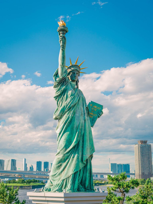

reshape position embedding from 196 to 576
load checkpoint from /content/drive/MyDrive/models/model_base_capfilt_large.pth
caption: the statue of liberty


In [ ]:
from models.FYP import FYP_decoder
image_size = 384
image = load_demo_image(image_size=image_size, device=device)

model_url = '/content/drive/MyDrive/models/model_base_capfilt_large.pth'
    
model = FYP_decoder(pretrained=model_url, image_size=image_size, vit='base')
model.eval()
model = model.to(device)

with torch.no_grad():
    # beam search
    caption = model.generate(image, sample=False, num_beams=3, max_length=20, min_length=5) 
    # nucleus sampling
    # caption = model.generate(image, sample=True, top_p=0.9, max_length=20, min_length=5) 
    print('caption: '+caption[0])

## **Image Text Matching**


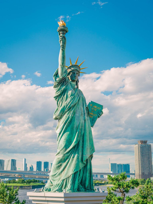

load checkpoint from /content/drive/MyDrive/models/model_base_retrieval_coco.pth
text: the statue of liberty
The image and text is matched with a probability of 0.9887
The image feature and text feature has a cosine similarity of 0.4614


In [ ]:
from models.FYP_itm import FYP_itm

image_size = 384
image = load_demo_image(image_size=image_size,device=device)

model_url = '/content/drive/MyDrive/models/model_base_retrieval_coco.pth'
    
model = FYP_itm(pretrained=model_url, image_size=image_size, vit='base')
model.eval()
model = model.to(device='cpu')

caption = 'the statue of liberty'

print('text: %s' %caption)

itm_output = model(image,caption,match_head='itm')
itm_score = torch.nn.functional.softmax(itm_output,dim=1)[:,1]
print('The image and text is matched with a probability of %.4f'%itm_score)

itc_score = model(image,caption,match_head='itc')
print('The image feature and text feature has a cosine similarity of %.4f'%itc_score)

## **Feature Extraction**

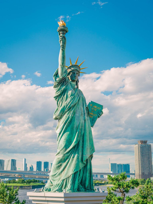

load checkpoint from /content/drive/MyDrive/models/model_base.pth


In [ ]:
from models.FYP import FYP_feature_extractor

image_size = 224
image = load_demo_image(image_size=image_size, device=device)     

model_url = '/content/drive/MyDrive/models/model_base.pth'
    
model = FYP_feature_extractor(pretrained=model_url, image_size=image_size, vit='base')
model.eval()
model = model.to(device)

caption = 'the statue of liberty'

multimodal_feature = model(image, caption, mode='multimodal')[0,0]
image_feature = model(image, caption, mode='image')[0,0]
text_feature = model(image, caption, mode='text')[0,0]